## Quickstart

In this brief tutorial, we'll run a quick simulation that illustrates the impact of cross-trait assortative mating on the the Haseman-Elston regression genetic correlation estimator. In the process, we'll learning about the essential components of an `xftsim` simulation.

### Setting up a simulation

In [1]:
import xftsim as xft
from xftsim.sim import Simulation
import numpy as np
import pandas as pd
import seaborn as sns

xft.config.print_durations_threshold=10. ## reduce verbosity
np.random.seed(123) ## set random seed for reproducibility

`Simulation` objects require the following arguments:

  - `founder_haplotypes: xarray.core.dataarray.DataArray,`
  - `architecture: xftsim.arch.Architecture,`
  - `recombination_map: xftsim.reproduce.RecombinationMap,`
  - `mating_regime: xftsim.mate.MatingRegime,`
 
 Together, these comprise our initial generation's haplotypes (`founder_haplotypes`), a phenogenetic architecture mapping genotypes to phenotypes (`architecture`), a method for assigning mates (`mating_regime`), and a recombination map for meiosis (`recombination_map`).
 
 We can also supply the following iterables:
 
  - `statistics: Iterable = [],`
  - `post_processors: Iterable = [],`
 
which correspond to any estimators (`statistics`) or other procedures (`post_processors`) we'd like to run every generation. 

For our **founder haplotypes**, we'll simply generate independent binomial random variants for `n=8000` individuals at `m=1000` diploid sites: 

In [2]:
founder_haplotypes = xft.founders.founder_haplotypes_uniform_AFs(n=8000,
                                                                 m=1000)
founder_haplotypes

<xarray.DataArray 'HaplotypeArray' (sample: 8000, variant: 2000)>
array([[1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int8)
Coordinates: (12/13)
  * sample       (sample) <U16 '0..0_0.0_0' '0..0_1.0_1' ... '0..0_7999.0_7999'
    iid          (sample) object '0_0' '0_1' '0_2' ... '0_7998' '0_7999'
    fid          (sample) object '0_0' '0_1' '0_2' ... '0_7998' '0_7999'
    sex          (sample) int64 0 1 0 1 0 1 0 1 0 1 0 ... 1 0 1 0 1 0 1 0 1 0 1
  * variant      (variant) <U5 '0.0' '0.1' '1.0' ... '998.1' '999.0' '999.1'
    vid          (variant) object '0' '0' '1' '1' ... '998' '998' '999' '999'
    ...           ...
    hcopy        (variant) object '0' '1' '0' '1' '0' ... '1' '0' '1' '0' '1'
    zero_allele  (variant) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    one_allele   (variant) object 'G' 'G' 'G' 'G' 'G' ... 'G' 'G' 'G' 'G' 'G'
    af           (variant) float64 0.6572 0.6572 0.3289 ... 0.1033 0.3359 0.3359
    pos_bp       (variant) float64 nan nan nan nan nan ... nan nan nan nan nan
    pos_cM       (variant) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    generation:  0

For our **genetic architecture**, we will use the independent GCTA model, where for each individual we have

$$y = m^{-1/2}X\beta + e$$
$$\beta\overset{iid}{\sim}N(0, h^2)$$
$$e\sim N(0, 1-h^2)$$

for heritability $h^2 \in [0,1]$. This can be implemented in `xftsim` via the `arch.GCTA_Architecture` class:

In [3]:
architecture = xft.arch.GCTA_Architecture(
    h2=[.5,.5],
    phenotype_name=['pheno_1', 'pheno_2'],
    haplotypes=founder_haplotypes)

To keep things simple, we will use an exchangleable **recombination map** wherein recombination occurs between contiguous loci with independent probability `p=.1`: 

In [4]:
recombination_map = xft.reproduce.RecombinationMap.constant_map_from_haplotypes(founder_haplotypes,
                                                                                p =.1)

Finally, we choose our **mating regime** to reflect cross-trait assortative mating on a linear combination of two phenotypes with an exchangeable correlation of 0.5.
Concretely, given female and male phenotypes $Y,\tilde{Y}\in R^{n\times2}$, respectively, we will find a mating permutation $P$

such that the empirical correlation is
$$\text{corr}(Y,P\tilde{Y})=0.5\cdot1_{2×2}.$$

We will have each couple generate two offspring, maintaining a constant population size. We implement this regime below:

In [5]:
mating_regime = xft.mate.LinearAssortativeMatingRegime(r = .5, 
    component_index = xft.index.ComponentIndex.from_product(['pheno_1', 'pheno_2'],
                                                            ['phenotype']),
    offspring_per_pair=2)

At each generation, we will request sample statistics and HE regression estimates. We will also use the `xft.proc.LimitMemory` post-processor to erase all but the most recent generation's haplotypes in order to conserve memory:

In [6]:
statistics = [xft.stats.MatingStatistics(),
              xft.stats.SampleStatistics(),
              xft.stats.HasemanElstonEstimator()]

post_processors = [xft.proc.LimitMemory(n_haplotype_generations=1)]

### Running a simulation

Our simulation is constructed by supplying each of the above to the `Simulation` constructor:

In [7]:
sim = Simulation(founder_haplotypes=founder_haplotypes,
                 mating_regime=mating_regime,
                 recombination_map=recombination_map,
                 architecture=architecture,
                 statistics=statistics,
                 post_processors=post_processors,)

We will run the simulation for 5 generations, which takes just a few seconds on a laptop:

In [8]:
%time sim.run(5)

CPU times: user 17.2 s, sys: 5.04 s, total: 22.3 s
Wall time: 7.39 s


The most recent generations are accessible in as a `dict` object in  `sim.results`, and all generations' results are stored in `sim.results_store`. First let's check that mating proceded as expected:

In [9]:
## generation 0
sim.results_store[0]['mating_statistics']['mate_correlations']

component,pheno_1.phenotype.mother,pheno_2.phenotype.mother,pheno_1.phenotype.father,pheno_2.phenotype.father
component,,,,
pheno_1.phenotype.mother,1.000000,-0.047681,0.463318,0.448655
pheno_2.phenotype.mother,-0.047681,1.000000,0.449102,0.462603
pheno_1.phenotype.father,0.463318,0.449102,1.000000,-0.043387
pheno_2.phenotype.father,0.448655,0.462603,-0.043387,1.000000


In [10]:
## generation 4
sim.results_store[4]['mating_statistics']['mate_correlations']
## same as 
sim.results['mating_statistics']['mate_correlations']


component,pheno_1.phenotype.mother,pheno_2.phenotype.mother,pheno_1.phenotype.father,pheno_2.phenotype.father
component,,,,
pheno_1.phenotype.mother,1.000000,0.110003,0.480770,0.502127
pheno_2.phenotype.mother,0.110003,1.000000,0.503734,0.502302
pheno_1.phenotype.father,0.480770,0.503734,1.000000,0.106810
pheno_2.phenotype.father,0.502127,0.502302,0.106810,1.000000


Next, let's compare three quanitites across generations:
 - `rho_beta_true`, the correlation between true genetic effects for `pheno_1` and `pheno_2`, which doesn't vary over time
 - `rho_score_true`, the correlation between true polygenic scores for `pheno_1` and `pheno_2`, which reflects changes in genetic architecture induced by xAM
 - `rho_beta_HE`, the HE-regression estimate of `rho_beta_true`, which is biased upwards under xAM

<Axes: xlabel='generation', ylabel='genetic correlation measure'>

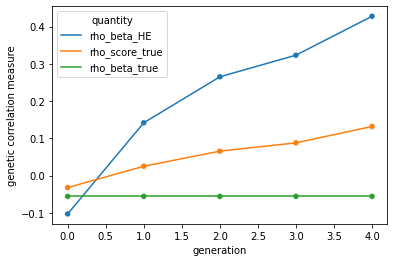

In [11]:
results = pd.DataFrame.from_records([{'generation':key, 
  'rho_beta_HE':value['HE_regression']['corr_HE'].iloc[1,0],
  'rho_score_true':value['sample_statistics']['vcov'].iloc[1,0],
  'rho_beta_true':sim.architecture.components[0].true_rho_beta[1,0]} for key,value in sim.results_store.items()]
                         )

pdat = pd.melt(results, id_vars='generation', var_name='quantity',
               value_name='genetic correlation measure')
sns.lineplot(data=pdat, 
           x='generation',
           y='genetic correlation measure',
           hue='quantity',)
sns.scatterplot(data=pdat, 
           x='generation',
           y='genetic correlation measure',
           hue='quantity',legend=False)

Finally, we save the generation 4 genotypes to disk. Here, we write to zarr, an efficient parallel format ideal for cases where we'd like to reload the data into python, but also to the plink binary format:

In [12]:
xft.io.write_to_plink1(sim.haplotypes, '/tmp/plink_output')

/home/rsb/Dropbox/ftsim/xftsim/xftsim/io.py:194: UserWarning: Writing to the plink bfile format removes phase information
  warnings.warn("Writing to the plink bfile format removes phase information")
Writing BED: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.46it/s]

Writing FAM... done.
Writing BIM... done.



/home/rsb/miniconda3/lib/python3.9/site-packages/pandas_plink/_write.py:261: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  df.to_csv(
/home/rsb/miniconda3/lib/python3.9/site-packages/pandas_plink/_write.py:288: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  df.to_csv(


In [13]:
xft.io.save_haplotype_zarr(sim.haplotypes, '/tmp/zarr_output', mode='w')

In [16]:
sim.phenotypes.xft.as_pd()

,,phenotype_name,pheno_1,pheno_2,pheno_1,pheno_2,pheno_1,pheno_2
,,component_name,additiveGenetic,additiveGenetic,additiveNoise,additiveNoise,phenotype,phenotype
,,vorigin_relative,proband,proband,proband,proband,proband,proband
iid,fid,sex,,,,,,
4_0,4_0,0,-0.678434,-2.158001,-0.002914,-0.362107,-0.681348,-2.520108
4_1,4_0,0,-1.021337,-2.865483,0.189355,0.207299,-0.831982,-2.658183
4_2,4_1,0,-2.083415,-2.065446,1.325921,0.199160,-0.757493,-1.866286
4_3,4_1,0,-1.820530,-0.952273,-0.652625,1.048390,-2.473155,0.096116
4_4,4_2,0,-1.258851,-1.853712,-0.593752,-0.475246,-1.852602,-2.328958
...,...,...,...,...,...,...,...,...
4_7995,4_3997,1,2.511000,1.406285,1.210872,0.930285,3.721872,2.336570
